<a href="https://colab.research.google.com/github/palver7/deeplearning/blob/master/FashionMNIST_with_VGG16_no_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from torchvision.datasets import FashionMNIST
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import random_split,DataLoader
import os
import copy

plt.ion()

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
samples = 64 #num of sample per batch
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(224),
        transforms.Grayscale(3),
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

trainset = FashionMNIST(root='./data', train=True, 
                        download=True, transform=data_transforms['train'])

trainset, valset = random_split(trainset, (50000,10000))

trainloader = DataLoader(trainset, batch_size=samples, shuffle=True, 
                                          num_workers=4)

testset = FashionMNIST(root='./data', train=False, 
                       download=True,transform=data_transforms['test'])

testloader = DataLoader(testset, batch_size=samples, shuffle=False, 
                                         num_workers=4)

valloader = DataLoader(valset, batch_size=samples, shuffle=False, 
                                         num_workers=4)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {'train': trainloader, 'val': valloader, 'test': testloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  Bag Trouser Trouser   Bag  Coat Pullover   Bag Pullover   Bag Ankle Boot


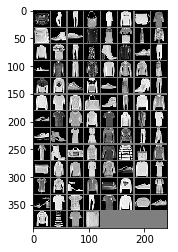

In [0]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [0]:
def train_model(model, criterion, optimizer, scheduler, val_acc, 
                val_loss, train_acc, train_loss, epoch,
                num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    list = {'train': {'acc': train_acc, 'loss': train_loss}, 
        'val':{'acc': val_acc, 'loss': val_loss}}
    next = epoch
    for epoch in range(next, next + num_epochs):
        print('Epoch {}/{}'.format(epoch, next + num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        
            running_loss = 0.0
            running_corrects = 0
        
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()
        
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            list[phase]['loss'].append(epoch_loss)
            list[phase]['acc'].append(epoch_acc.item())
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
        
    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, epoch + 1

In [0]:
model = torchvision.models.vgg16(pretrained=False)
#for param in model.parameters():
#    param.requires_grad = False


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
# Lists for plotting loss and accuracy.
# Rerun this cell if you want to restart training to empty the lists.
epoch = 0
val_acc = []
val_loss = []
train_acc = []
train_loss = []

In [0]:
model, epoch = train_model(model, criterion, optimizer, scheduler, val_acc, val_loss, 
                    train_acc, train_loss, epoch, num_epochs=5)

Epoch 0/4
----------
train Loss: 2.3027 Acc: 0.0948
val Loss: 2.3027 Acc: 0.1000

Epoch 1/4
----------
train Loss: 2.3026 Acc: 0.0961
val Loss: 2.3027 Acc: 0.0953

Epoch 2/4
----------
train Loss: 2.3026 Acc: 0.1005
val Loss: 2.3027 Acc: 0.0789

Epoch 3/4
----------
train Loss: 2.3026 Acc: 0.1008
val Loss: 2.3027 Acc: 0.0951

Epoch 4/4
----------
train Loss: 2.3026 Acc: 0.0989
val Loss: 2.3027 Acc: 0.0951

Training complete in 53m 16s
Best val Acc: 0.100000


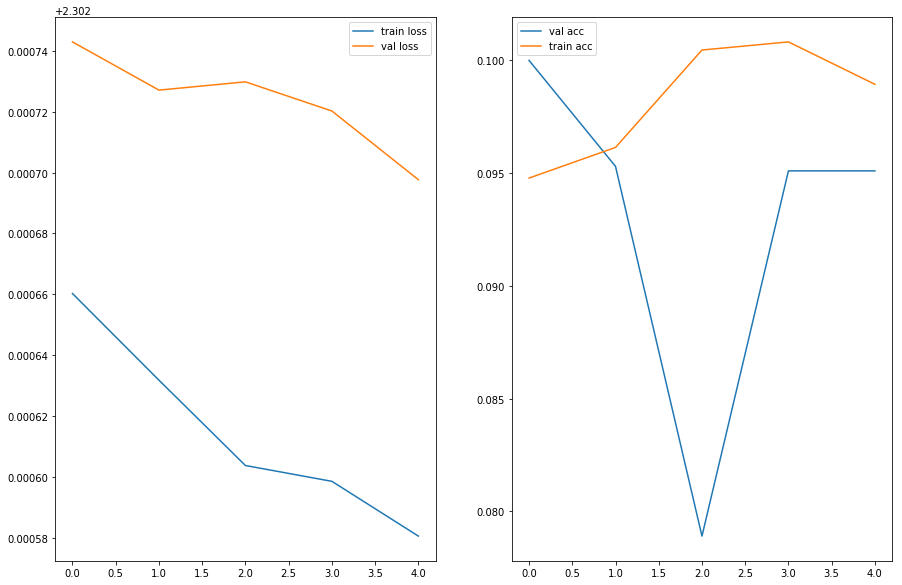

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(train_loss, label='train loss')
ax1.plot(val_loss, label='val loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(val_acc, label='val acc')
ax2.plot(train_acc, label='train acc')
ax2.legend()

GroundTruth:  Ankle Boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt Sandal Sneaker


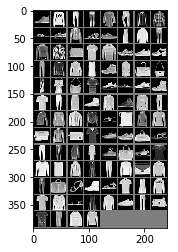

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] \
                                for j in range(10)))

Predicted:  Sandal Sandal Sandal Sandal Sandal Sandal Sandal Sandal Sandal Sandal


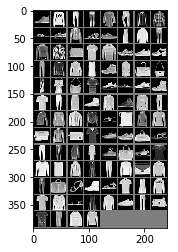

In [0]:
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
imshow(torchvision.utils.make_grid(images.cpu()))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] \
                              for j in range(10)))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on the test images : %.4f' %
     (correct/total))

Accuracy of the network on the test images : 0.1000


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
      
for i in range(10):
    print('Accuracy of %5s : %.4f' % 
         (classes[i], class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 0.0000
Accuracy of Trouser : 0.0000
Accuracy of Pullover : 0.0000
Accuracy of Dress : 0.0000
Accuracy of  Coat : 0.0000
Accuracy of Sandal : 1.0000
Accuracy of Shirt : 0.0000
Accuracy of Sneaker : 0.0000
Accuracy of   Bag : 0.0000
Accuracy of Ankle Boot : 0.0000


Comparing training and validation accuracy and the training time of feature extraction (freezing the backpropagation), finetuning the model (use pretrained model, not freezing the backpropagation), and training the model from scratch ( no pretrained model).

###the feature extraction results are:

Epoch 0/4
----------
train Loss: 0.6864 Acc: 0.7600
val Loss: 0.4958 Acc: 0.8225

Epoch 1/4
----------
train Loss: 0.5574 Acc: 0.7994
val Loss: 0.4503 Acc: 0.8417

Epoch 2/4
----------
train Loss: 0.5351 Acc: 0.8061
val Loss: 0.4333 Acc: 0.8429

Epoch 3/4
----------
train Loss: 0.5220 Acc: 0.8101
val Loss: 0.4236 Acc: 0.8469

Epoch 4/4
----------
train Loss: 0.5106 Acc: 0.8119
val Loss: 0.4114 Acc: 0.8517

Training complete in 26m 45s
Best val Acc: 0.851700

###the finetuning results are:

Epoch 0/4
----------
train Loss: 0.6865 Acc: 0.7599
val Loss: 0.4896 Acc: 0.8274

Epoch 1/4
----------
train Loss: 0.5592 Acc: 0.7959
val Loss: 0.4537 Acc: 0.8373

Epoch 2/4
----------
train Loss: 0.5349 Acc: 0.8044
val Loss: 0.4302 Acc: 0.8452

Epoch 3/4
----------
train Loss: 0.5181 Acc: 0.8112
val Loss: 0.4200 Acc: 0.8506

Epoch 4/4
----------
train Loss: 0.5135 Acc: 0.8123
val Loss: 0.4234 Acc: 0.8447

Training complete in 67m 30s
Best val Acc: 0.850600

comparison between freezing the gradients and not is clear on the running time; the former is faster than the latter by 40 mins. The best val_acc does not change much. The finetuned model's val_acc in the final epoch decreased compared to the previous epoch.

### the result of training with 1 channel and not using pretrained parameters:

Epoch 0/4
----------
train Loss: 2.2778 Acc: 0.1721
val Loss: 2.2457 Acc: 0.3534

Epoch 1/4
----------
train Loss: 2.2295 Acc: 0.3020
val Loss: 2.1941 Acc: 0.4954

Epoch 2/4
----------
train Loss: 2.1837 Acc: 0.3752
val Loss: 2.1440 Acc: 0.5315

Epoch 3/4
----------
train Loss: 2.1411 Acc: 0.4208
val Loss: 2.0977 Acc: 0.6161

Epoch 4/4
----------
train Loss: 2.1017 Acc: 0.4500
val Loss: 2.0540 Acc: 0.6303

Training complete in 66m 0s
Best val Acc: 0.630300

the accuracy drops from ~ 80% to ~60% for validation, but the training time is only faster by 1.5 minutes compared to initialization with pretrained parameters. 

### the result of training with 3 channels without pretrained parameters:

Epoch 0/4
----------
train Loss: 2.2693 Acc: 0.1676
val Loss: 2.2274 Acc: 0.4331

Epoch 1/4
----------
train Loss: 2.2074 Acc: 0.3380
val Loss: 2.1611 Acc: 0.5245

Epoch 2/4
----------
train Loss: 2.1504 Acc: 0.4182
val Loss: 2.0998 Acc: 0.6302

Epoch 3/4
----------
train Loss: 2.0986 Acc: 0.4769
val Loss: 2.0435 Acc: 0.6414

Epoch 4/4
----------
train Loss: 2.0492 Acc: 0.5160
val Loss: 1.9901 Acc: 0.6633

Training complete in 67m 34s
Best val Acc: 0.663300

training is 1.5 mins slower than 1 channel, the increase in best val accuracy is 0.03 or 3% .

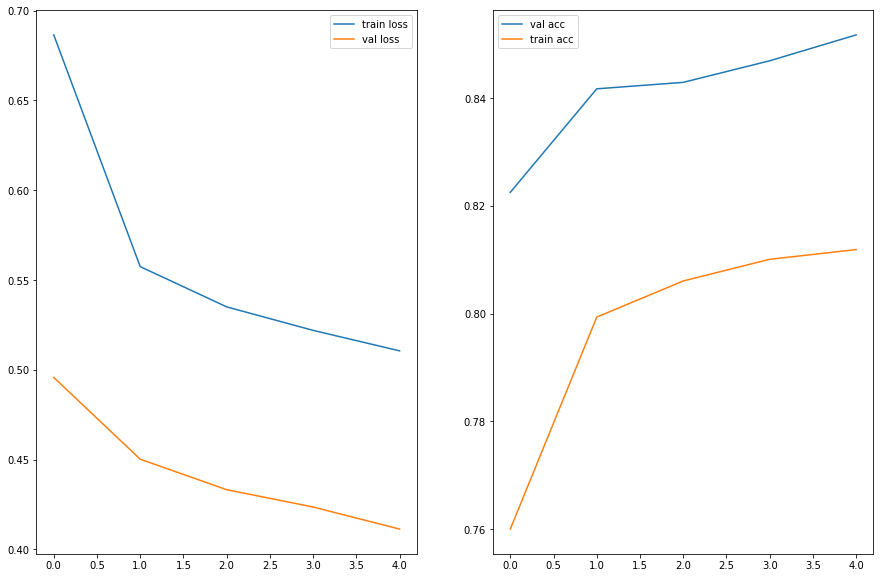

Result of feature extraction / freezing the backpropagation

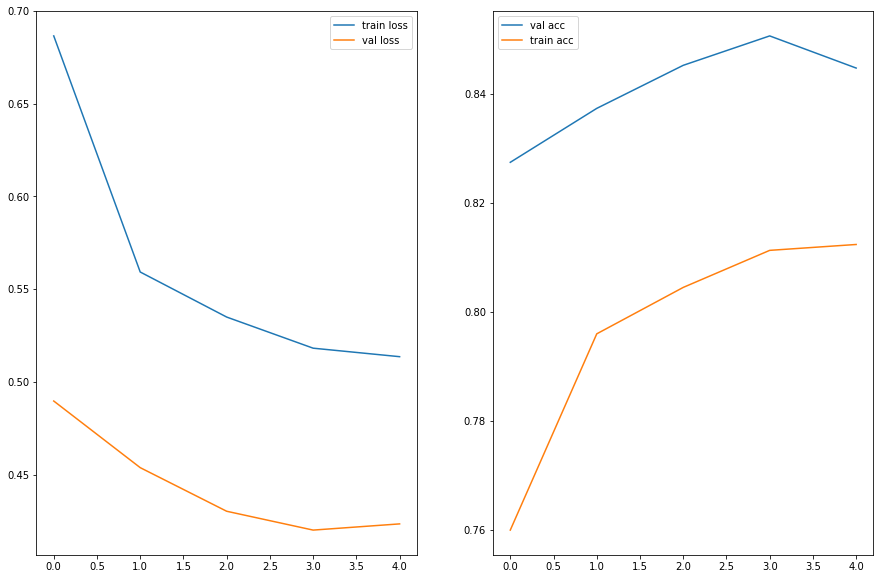

finetuning result initialized with pretrained model but  changing the neural network's parameters.

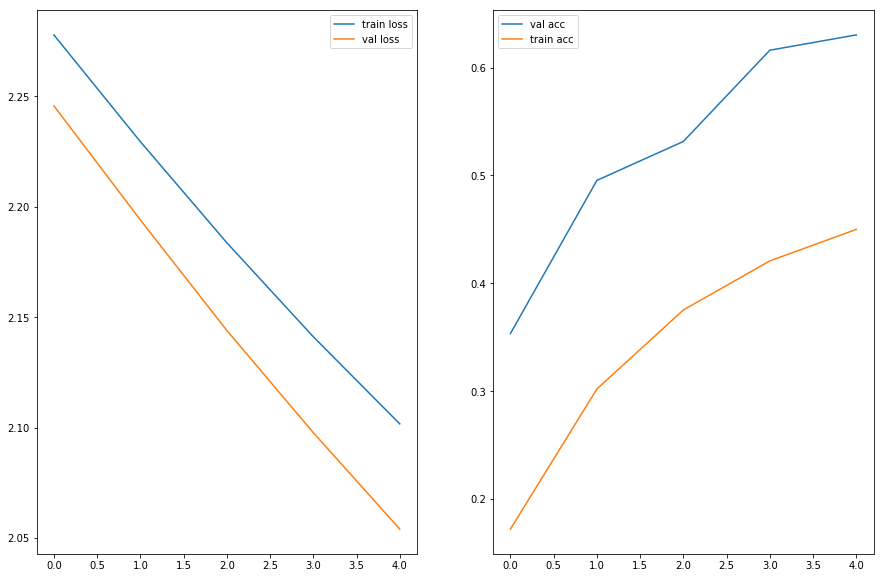

results of training the model with 1 channel and no pretrained parameters.

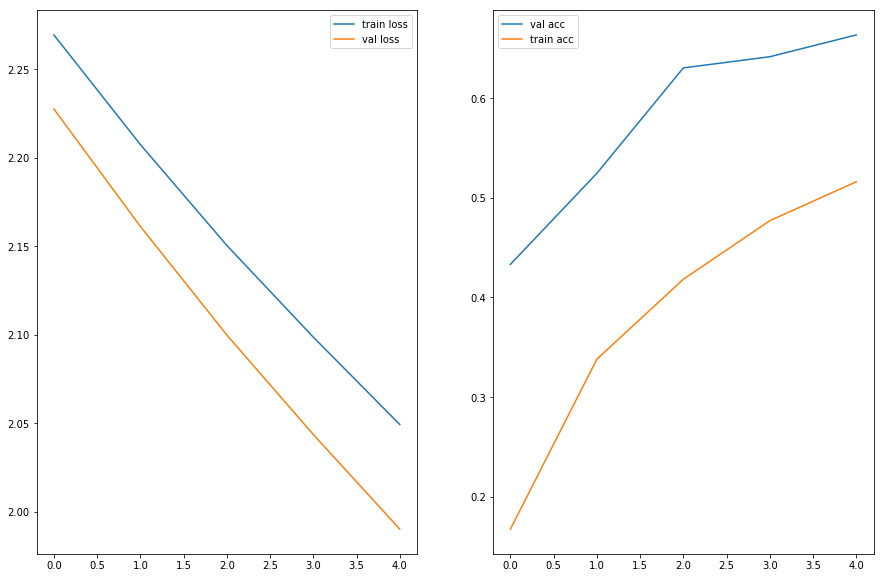

result of training with no pretrained parameters and using 3 channels.

In [0]:
torch.save({'epoch' : epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss, 'val_loss': val_loss, 
            'train_acc': train_acc, 'val_acc': val_acc}, 
           './FMNIST_VGG16_noresize.tar')

In [0]:
checkpoint = torch.load('./FMNIST_VGG16_noresize.tar')
model.load_state_dict(checkpoint['model_state_dict'])  
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']
val_loss = checkpoint['val_loss']
val_acc = checkpoint['val_acc']
epoch = checkpoint['epoch']
